In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import time
import copy

from torchvision.models import resnet18, ResNet18_Weights


In [ ]:

# Number of classes in the dataset
num_classes = 10

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for
num_epochs = 1

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing()])

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=20,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Create training and validation dataloaders
dataloaders_dict = {'train': trainloader, 'val':testloader}

Files already downloaded and verified
Files already downloaded and verified


horse  frog plane  bird


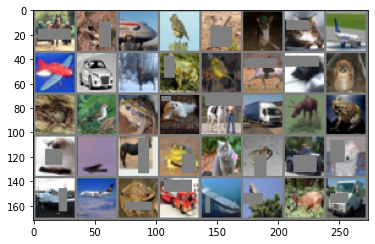

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)


# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
# Initialize model
weights = ResNet18_Weights.DEFAULT
model = resnet18(weights=weights)
model.fc = torch.nn.Linear(512, num_classes)


In [ ]:
# Send the model to GPU
model = model.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            #print("\t",name)
            None

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(params_to_update, lr=0.001, momentum=0.9)
#scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer_ft, gamma=0.95)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.5) #After 10 epochs reduce by 50%

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_uncertainty=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_uncertainty :

                        y = F.one_hot(labels, num_classes=num_classes)
                        y = y.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, y.float(), epoch, num_classes, 3, device)

                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            # schedulre  only if in training phase
            if phase == 'train':
                scheduler.step()
                print ("LR :", scheduler.get_lr())


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
# Setup the loss fxn
criterion = torch.nn.CrossEntropyLoss()

# Train and evaluateF
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=False)
# model_ft, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs)



In [ ]:
import torch
import torch.nn.functional as F

def get_device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def relu_evidence(y):
    return F.relu(y)


def exp_evidence(y):
    return torch.exp(torch.clamp(y, -5, 5)) # exp(5) is 200 which is good max for 14 class


def softplus_evidence(y):
    return F.softplus(y)


def kl_divergence(alpha, num_classes, device=None):
    if not device:
        device = get_device()
    ones = torch.ones([1, num_classes], dtype=torch.float32, device=device)
    sum_alpha = torch.sum(alpha, dim=1, keepdim=True)
    first_term = (
        torch.lgamma(sum_alpha)
        - torch.lgamma(alpha).sum(dim=1, keepdim=True)
        + torch.lgamma(ones).sum(dim=1, keepdim=True)
        - torch.lgamma(ones.sum(dim=1, keepdim=True))
    )
    second_term = (
        (alpha - ones)
        .mul(torch.digamma(alpha) - torch.digamma(sum_alpha))
        .sum(dim=1, keepdim=True)
    )
    kl = first_term + second_term
    return kl


def loglikelihood_loss(y, alpha, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)
    loglikelihood_err = torch.sum((y - (alpha / S)) ** 2, dim=1, keepdim=True)
    loglikelihood_var = torch.sum(
        alpha * (S - alpha) / (S * S * (S + 1)), dim=1, keepdim=True
    )
    loglikelihood = loglikelihood_err + loglikelihood_var
    return loglikelihood


def mse_loss(y, alpha, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    y = y.to(device)
    alpha = alpha.to(device)
    loglikelihood = loglikelihood_loss(y, alpha, device=device)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return loglikelihood + kl_div


def edl_loss(func, y, alpha, epoch_num, num_classes, annealing_step, device=None):
    y = y.to(device)
    alpha = alpha.to(device)
    S = torch.sum(alpha, dim=1, keepdim=True)

    A = torch.sum(y * (func(S) - func(alpha)), dim=1, keepdim=True)

    annealing_coef = torch.min(
        torch.tensor(1.0, dtype=torch.float32),
        torch.tensor(epoch_num / annealing_step, dtype=torch.float32),
    )

    kl_alpha = (alpha - 1) * (1 - y) + 1
    kl_div = annealing_coef * kl_divergence(kl_alpha, num_classes, device=device)
    return A + kl_div


def edl_mse_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        mse_loss(target, alpha, epoch_num, num_classes, annealing_step, device=device)
    )
    return loss


def edl_log_loss(output, target, epoch_num, num_classes, annealing_step, device=None):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.log, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss


def edl_digamma_loss(
    output, target, epoch_num, num_classes, annealing_step, device=None
):
    if not device:
        device = get_device()
    evidence = relu_evidence(output)
    alpha = evidence + 1
    loss = torch.mean(
        edl_loss(
            torch.digamma, target, alpha, epoch_num, num_classes, annealing_step, device
        )
    )
    return loss

In [ ]:
criterion =  edl_mse_loss
model, hist = train_model(model, dataloaders_dict, criterion, optimizer_ft, scheduler, num_epochs=num_epochs, is_uncertainty=True)  

Epoch 0/0
----------
tensor([[-9.9583e-01,  9.1320e-01, -1.5592e+00, -2.2845e-01, -6.9197e-01,
          2.5481e+00, -2.4172e+00,  1.2873e+00, -2.2333e-01, -2.5816e-01],
        [-1.1562e+00,  1.3397e+00, -1.3847e+00, -1.4860e+00, -9.8250e-02,
         -9.2973e-02,  3.2691e-02,  2.0732e+00,  7.6953e-01, -6.4443e-01],
        [-1.5237e+00, -1.0060e-01,  6.6758e-01,  2.4114e-01,  8.9495e-01,
         -8.4755e-01, -6.3283e-01,  7.2236e-01,  4.9380e-01, -4.0030e-01],
        [-1.1943e+00,  1.4068e-01, -1.0294e+00,  1.8647e-02,  9.3118e-01,
          9.6233e-01, -2.0119e-01,  9.0458e-01,  5.4914e-01,  1.0628e-01],
        [-1.5197e+00,  3.6778e-01, -5.7623e-01, -8.2994e-01, -7.2712e-02,
          9.9417e-01, -3.6453e-01,  4.3805e-01,  5.4609e-01,  1.0105e-01],
        [-6.1046e-01, -3.4820e-02, -7.3818e-02, -1.1374e+00,  7.6625e-01,
          2.8387e-01, -7.2348e-01,  2.8290e-02, -2.1326e-01, -2.2838e-02],
        [-2.1850e+00,  2.0349e+00, -1.7034e+00, -1.5304e+00, -1.9076e-01,
          2

/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:381: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


tensor([[-0.3940,  0.5939, -0.1802,  0.2624,  0.6379,  0.3082, -0.3277,  0.4866,
          0.8016,  0.2999],
        [-0.2806, -0.7572,  0.1924,  0.2104,  0.1986,  0.3674,  0.1190, -0.1235,
          0.3094, -0.3797],
        [-0.3739, -0.3412, -0.3448,  0.0789,  0.1234,  0.1407, -0.1120,  0.9376,
          0.1625, -0.0440],
        [-0.4632, -0.6269, -0.3687,  0.4966,  0.5270,  0.4172, -0.1137,  0.0095,
          0.3241,  0.2523],
        [-0.8315,  0.8255, -0.7593, -0.1279,  0.1679, -0.1973,  0.0041,  0.6448,
          0.3477,  0.1038],
        [-0.4298, -0.0431, -0.2404,  0.0286,  0.5898,  0.4283, -0.5319,  0.2664,
          0.5752,  0.0333],
        [-0.5543, -0.0622, -0.2639,  0.1463,  0.4043,  0.6323,  0.0832,  1.1134,
          0.9135,  0.3131],
        [-0.4453,  0.6703, -0.7315,  0.1627,  0.5025,  0.0383, -0.3628,  0.9371,
          0.2207,  0.0476],
        [-0.5838,  0.5343, -0.4771, -0.0738,  0.1185,  0.0479, -0.7344,  0.8527,
          0.0137,  0.0919],
        [-0.1230, -

In [ ]:
import pandas as pd
from scipy.stats import dirichlet, multinomial
import seaborn as sns

In [ ]:
all_alpha = []
all_labels = []
# Iterate over data.
for inputs, labels in testloader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    #evidence = exp_evidence(outputs)
    evidence = relu_evidence(outputs)
    alpha = evidence + 1
    all_alpha.extend(alpha.tolist() )
    all_labels.extend(labels.tolist())
        

all_alpha = np.array(all_alpha)
all_alpha.shape

(10000, 10)

## Entropy using Dirichlet distirbution 

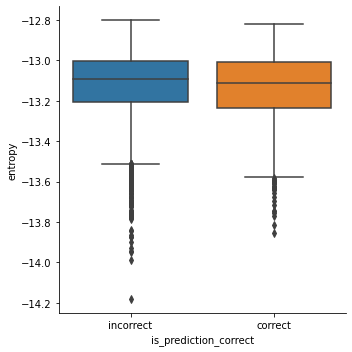

In [ ]:
all_alpha = pd.DataFrame(all_alpha)

def calculate_dirchlet_entropy( alphas ):
    return dirichlet(alphas).entropy()


all_alpha['entropy']=all_alpha.apply(lambda row: calculate_dirchlet_entropy( [row[0], row[1], row[2],
    row[3], row[4], row[5], row[6],row[7], row[8], row[9] ] ), axis=1)


all_alpha['true_labels'] = all_labels
all_alpha['predicted_label'] = all_alpha[[1,2,3,4,5,6,7,8,9]].idxmax(axis=1)


all_alpha['is_prediction_correct'] = all_alpha['true_labels'] == all_alpha['predicted_label']
all_alpha = all_alpha.astype({'entropy': 'float64'})


#sub = subset[subset['constraint'].isin(['normal', 'blur'])]
d = {True: 'correct', False: 'incorrect'}

all_alpha['is_prediction_correct'] = all_alpha['is_prediction_correct'].replace(d)

g = sns.catplot(
  data=all_alpha, y="entropy", x="is_prediction_correct",
  kind="box", height=5, aspect=1,
)


## Entropy using multinomial distirbution 

In [ ]:
all_alpha = pd.DataFrame(all_alpha)
all_alpha = all_alpha.div(all_alpha.sum(axis=1), axis=0) #CONVERT FROM DIRICHLET TO MULTINOMIAL 

all_alpha['true_labels'] = all_labels
all_alpha

In [ ]:
def calculate_multinomial_entropy( p_values ):
    return multinomial(1, p_values).entropy()


all_alpha['entropy']=all_alpha.apply(lambda row: calculate_multinomial_entropy( [row[0], row[1], row[2],
    row[3], row[4], row[5], row[6],row[7], row[8], row[9] ] ), axis=1)

In [ ]:
all_alpha['predicted_label'] = all_alpha[[1,2,3,4,5,6,7,8,9]].idxmax(axis=1)


all_alpha['is_prediction_correct'] = all_alpha['true_labels'] == all_alpha['predicted_label']
all_alpha = all_alpha.astype({'entropy': 'float64'})

In [ ]:
#sub = subset[subset['constraint'].isin(['normal', 'blur'])]
d = {True: 'correct', False: 'incorrect'}

all_alpha['is_prediction_correct'] = all_alpha['is_prediction_correct'].replace(d)

g = sns.catplot(data=all_alpha, y="entropy", x="is_prediction_correct", kind="box", height=5, aspect=1,)

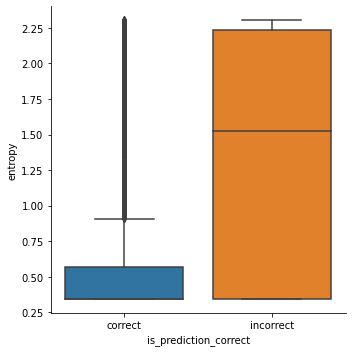